<a href="https://colab.research.google.com/github/dudaholandah/NLP/blob/main/Projeto/IndianFood_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r '/content/drive/MyDrive/NLP-Project/indian-food' 'indian-food'

# Imports

In [ ]:
!pip install gensim --upgrade
!pip install keras
!pip install tensorflow
!pip install keras-tuner --upgrade
!pip install glove-python-binary

In [ ]:
#WORD2VEC
from gensim.models import Word2Vec
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
nltk.download('punkt')
#GLOVE
from glove import Corpus, Glove
#Neural Network
import keras_tuner as kt
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense,Conv1D,Embedding,GlobalMaxPooling1D,Activation,SimpleRNN,Dropout,Masking,LSTM
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.optimizers import SGD
from keras_tuner import HyperModel
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
#Data
import json
import os
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

# Data

In [ ]:
path = 'indian-food/indian_food.csv'
df_indian = pd.read_csv(path)

In [ ]:
df_indian.head(5)

,name,ingredients,diet,prep_time,cook_time,flavor_profile,course,state,region
0,Balu shahi,"Maida flour, yogurt, oil, sugar",vegetarian,45,25,sweet,dessert,West Bengal,East
1,Boondi,"Gram flour, ghee, sugar",vegetarian,80,30,sweet,dessert,Rajasthan,West
2,Gajar ka halwa,"Carrots, milk, sugar, ghee, cashews, raisins",vegetarian,15,60,sweet,dessert,Punjab,North
3,Ghevar,"Flour, ghee, kewra, milk, clarified butter, su...",vegetarian,15,30,sweet,dessert,Rajasthan,West
4,Gulab jamun,"Milk powder, plain flour, baking powder, ghee,...",vegetarian,15,40,sweet,dessert,West Bengal,East


## Pre-Processing

In [ ]:
def pre_processing(text):
  new = ""
  for word in text.split(','):
    word = re.sub(r'[^\w\s]', '', word.lower())
    word = re.sub(r'[0-9]+', '', word)
    word = re.sub(r'\boz\b', '', word)
    word = re.sub(r'\ba taste of\b', '', word)
    new = new + word.strip() + " "

  return new[:-1]

In [ ]:
df_indian['ingredients'] = [pre_processing(x) for x in df_indian['ingredients']]

In [ ]:
X = df_indian['ingredients']
y = df_indian['diet']

# dados de teste = 20% do treinamento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# dados de validacao = 50% do teste
X_test, X_valid, y_test, y_valid = train_test_split(X, y, test_size=0.5)

In [ ]:
y_train = pd.Categorical(y_train)
y_train_int = y_train.codes

y_valid = pd.Categorical(y_valid)
y_valid_int = y_valid.codes

y_test = pd.Categorical(y_test)
target_names = y_test.categories
y_test_int = y_test.codes

y_train = to_categorical(y_train_int)
y_valid = to_categorical(y_valid_int)
y_test = to_categorical(y_test_int)

# Embeddings

In [ ]:
MAX_LENGTH = 12

## Word2Vec

In [ ]:
def create_embedding_w2v(tokenizer, model, vocab_size, embedding_dim):
  embedding_w2v = np.zeros((vocab_size, embedding_dim))
  for word, i in tokenizer.word_index.items():
    if word in model.wv:
      embedding_w2v[i] = model.wv.get_vector(word)
    else:
      embedding_w2v[i]=np.random.normal(0,np.sqrt(0.25), embedding_dim)
  return embedding_w2v

In [ ]:
# Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
# Train Data
encoded_w2v = tokenizer.texts_to_sequences(X_train)
X_train_w2v_padded = pad_sequences(encoded_w2v, maxlen=MAX_LENGTH, padding='post', truncating='post')

# Valid Data
encoded_w2v = tokenizer.texts_to_sequences(X_valid)
X_valid_w2v_padded = pad_sequences(encoded_w2v, maxlen=MAX_LENGTH, padding='post', truncating='post')

# Test Data
encoded_w2v = tokenizer.texts_to_sequences(X_test)
X_test_w2v_padded = pad_sequences(encoded_w2v, maxlen=MAX_LENGTH, padding='post', truncating='post')

In [ ]:
# EMBEDDING LAYER

EMBEDDING_DIM_W2V = 50

sentences = [sentence.split() for sentence in X_train]
model_word2vec = Word2Vec(sentences, vector_size=EMBEDDING_DIM_W2V, min_count=1, window=5, sg=1,workers=4)

embedding_w2v = create_embedding_w2v(tokenizer, model_word2vec, vocab_size, EMBEDDING_DIM_W2V)

## GloVe

In [ ]:
def create_embedding_glove(glove, vocab_size, embedding_dim):
  embedding_glove = np.zeros((vocab_size, embedding_dim))
  for i, word in enumerate(glove.dictionary):
    embedding_glove[i+1] = glove.word_vectors[i]
  return embedding_glove

In [ ]:
def texts_to_sequences(df_text):
  encoded_glove = []
  for sentence in df_text:
    xs = []
    for word in sentence.split():
      if glove.dictionary.get(word) is not None:
        xs.append(glove.dictionary[word]+1)
      else:
        xs.append(0)
    encoded_glove.append(xs)
  return encoded_glove

In [ ]:
corpus = Corpus() 
 
sentences = [sentence.split() for sentence in X_train]
corpus.fit(sentences, window=10)

In [ ]:
# EMBEDDING LAYER

EMBEDDING_DIM_GLV = 50

glove = Glove(no_components=EMBEDDING_DIM_GLV, learning_rate=0.05)
glove.fit(corpus.matrix, epochs=30, no_threads=2)
glove.add_dictionary(corpus.dictionary)
embedding_glove = create_embedding_glove(glove, vocab_size, EMBEDDING_DIM_GLV)

In [ ]:
# Train Data
encoded_glove = texts_to_sequences(X_train)
X_train_glove_padded = pad_sequences(encoded_glove, maxlen=MAX_LENGTH, padding='post', truncating='post')

# Valid Data
encoded_glove = texts_to_sequences(X_valid)
X_valid_glove_padded = pad_sequences(encoded_glove, maxlen=MAX_LENGTH, padding='post', truncating='post')

# Test Data
encoded_glove = texts_to_sequences(X_test)
X_test_glove_padded = pad_sequences(encoded_glove, maxlen=MAX_LENGTH, padding='post', truncating='post')

# CNN

In [ ]:
class CNNHyperModel(HyperModel):
  def __init__(self, embedding_layer, output):
    self.embedding_layer = embedding_layer
    self.output = output

  def build(self, hp):
    model = Sequential()
    model.add(self.embedding_layer)
    model.add(Conv1D(filters=hp.Choice("conv", [64,128,256]), kernel_size=6, strides=1, activation='relu'))
    model.add(Dropout(0.5))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(hp.Choice("dense1", [64,128]), activation='relu'))
    model.add(Dense(hp.Choice("dense2", [32,64]), activation='relu'))
    model.add(Dense(self.output, activation='softmax'))
    sgd = SGD(learning_rate=0.01)
    model.compile(loss="categorical_crossentropy",optimizer=sgd,metrics=['accuracy'])
    return model

### WORD2VEC

In [ ]:
embedding_layer = Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM_W2V, weights=[embedding_w2v], input_length=MAX_LENGTH, trainable=False)

In [ ]:
model_CNN = CNNHyperModel(embedding_layer, 2)

In [ ]:
tuner = kt.Hyperband(
    model_CNN,
    objective='val_accuracy',
    max_epochs=30,
    hyperband_iterations=2,
    overwrite=True)

In [ ]:
tuner.search(X_train_w2v_padded,y_train,validation_data=(X_valid_w2v_padded,y_valid),epochs=50)

Trial 12 Complete [00h 00m 03s]
val_accuracy: 0.8984375

Best val_accuracy So Far: 0.8984375
Total elapsed time: 00h 00m 31s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
model = tuner.hypermodel.build(best_hps)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 12, 50)            15300     
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 256)            77056     
                                                                 
 dropout_1 (Dropout)         (None, 7, 256)            0         
                                                                 
 global_max_pooling1d_1 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_3 (Dense)             (None, 64)                16448     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                      

In [ ]:
history_fine = model.fit(X_train_w2v_padded,y_train,validation_data=(X_valid_w2v_padded,y_valid), epochs=100) 

Epoch 1/100
7/7 [==============================] - 1s 41ms/step - loss: 0.6784 - accuracy: 0.6863 - val_loss: 0.6446 - val_accuracy: 0.8984
Epoch 2/100
7/7 [==============================] - 0s 10ms/step - loss: 0.6106 - accuracy: 0.8824 - val_loss: 0.5824 - val_accuracy: 0.8984
Epoch 3/100
7/7 [==============================] - 0s 10ms/step - loss: 0.5462 - accuracy: 0.8824 - val_loss: 0.5342 - val_accuracy: 0.8984
Epoch 4/100
7/7 [==============================] - 0s 12ms/step - loss: 0.4967 - accuracy: 0.8824 - val_loss: 0.4950 - val_accuracy: 0.8984
Epoch 5/100
7/7 [==============================] - 0s 11ms/step - loss: 0.4585 - accuracy: 0.8824 - val_loss: 0.4648 - val_accuracy: 0.8984
Epoch 6/100
7/7 [==============================] - 0s 13ms/step - loss: 0.4321 - accuracy: 0.8824 - val_loss: 0.4440 - val_accuracy: 0.8984
Epoch 7/100
7/7 [==============================] - 0s 11ms/step - loss: 0.4142 - accuracy: 0.8824 - val_loss: 0.4255 - val_accuracy: 0.8984
Epoch 8/100
7/7 [===

In [ ]:
target_names = pd.Categorical(df_indian['diet']).categories

In [ ]:
y_prob = model.predict(X_test_w2v_padded)
y_pred = np.argmax(y_prob,axis=1)
print(classification_report(y_test_int,y_pred, target_names=target_names, zero_division=1))

                precision    recall  f1-score   support

non vegetarian       1.00      0.00      0.00        16
    vegetarian       0.87      1.00      0.93       111

      accuracy                           0.87       127
     macro avg       0.94      0.50      0.47       127
  weighted avg       0.89      0.87      0.82       127



In [ ]:
if not os.path.exists("figs"):
    os.mkdir("figs")

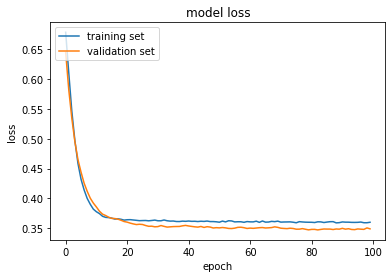

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.savefig('figs/loss_cnn_w2v.eps', format='eps')
plt.show()

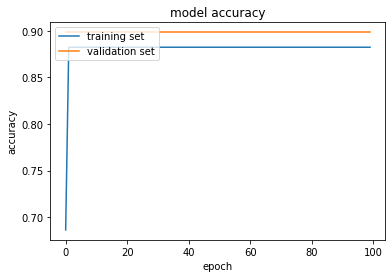

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.savefig('figs/acc_cnn_w2v.eps', format='eps')
plt.show()

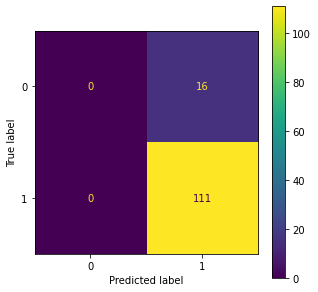

<Figure size 432x288 with 0 Axes>

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(y_test_int, y_pred)
fig = disp.ax_.get_figure()  
fig.set_figwidth(5) 
fig.set_figheight(5)
plt.savefig('figs/matrixconf_cnn_w2v.eps', format='eps')
plt.show()

### GLOVE

In [ ]:
embedding_layer = Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM_GLV, weights=[embedding_glove], input_length=MAX_LENGTH, trainable=False)

In [ ]:
model_CNN = CNNHyperModel(embedding_layer, 2)

In [ ]:
tuner = kt.Hyperband(
    model_CNN,
    objective='val_accuracy',
    max_epochs=30,
    hyperband_iterations=2,
    overwrite=True)

In [ ]:
tuner.search(X_train_glove_padded,y_train,validation_data=(X_valid_glove_padded,y_valid),epochs=50)

Trial 12 Complete [00h 00m 01s]
val_accuracy: 0.8984375

Best val_accuracy So Far: 0.8984375
Total elapsed time: 00h 00m 16s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
model = tuner.hypermodel.build(best_hps)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 12, 50)            15300     
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 64)             19264     
                                                                 
 dropout_1 (Dropout)         (None, 7, 64)             0         
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_3 (Dense)             (None, 128)               8320      
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                      

In [ ]:
history_fine = model.fit(X_train_glove_padded,y_train,validation_data=(X_valid_glove_padded,y_valid), epochs=100) 

Epoch 1/100
7/7 [==============================] - 1s 42ms/step - loss: 0.6696 - accuracy: 0.8676 - val_loss: 0.6423 - val_accuracy: 0.8984
Epoch 2/100
7/7 [==============================] - 0s 8ms/step - loss: 0.6190 - accuracy: 0.8824 - val_loss: 0.5997 - val_accuracy: 0.8984
Epoch 3/100
7/7 [==============================] - 0s 10ms/step - loss: 0.5751 - accuracy: 0.8824 - val_loss: 0.5627 - val_accuracy: 0.8984
Epoch 4/100
7/7 [==============================] - 0s 8ms/step - loss: 0.5372 - accuracy: 0.8824 - val_loss: 0.5297 - val_accuracy: 0.8984
Epoch 5/100
7/7 [==============================] - 0s 8ms/step - loss: 0.5047 - accuracy: 0.8824 - val_loss: 0.5017 - val_accuracy: 0.8984
Epoch 6/100
7/7 [==============================] - 0s 10ms/step - loss: 0.4774 - accuracy: 0.8824 - val_loss: 0.4770 - val_accuracy: 0.8984
Epoch 7/100
7/7 [==============================] - 0s 10ms/step - loss: 0.4533 - accuracy: 0.8824 - val_loss: 0.4560 - val_accuracy: 0.8984
Epoch 8/100
7/7 [======

In [ ]:
target_names = pd.Categorical(df_indian['diet']).categories

In [ ]:
y_prob = model.predict(X_test_glove_padded)
y_pred = np.argmax(y_prob,axis=1)
print(classification_report(y_test_int,y_pred, target_names=target_names, zero_division=1))

                precision    recall  f1-score   support

non vegetarian       1.00      0.00      0.00        16
    vegetarian       0.87      1.00      0.93       111

      accuracy                           0.87       127
     macro avg       0.94      0.50      0.47       127
  weighted avg       0.89      0.87      0.82       127



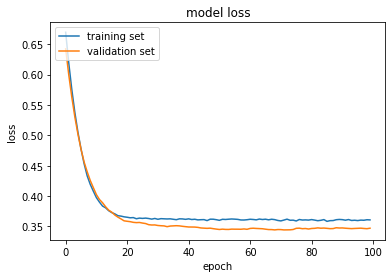

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.savefig('figs/loss_cnn_glv.eps', format='eps')
plt.show()

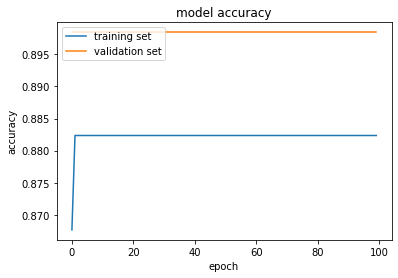

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.savefig('figs/acc_cnn_glv.eps', format='eps')
plt.show()

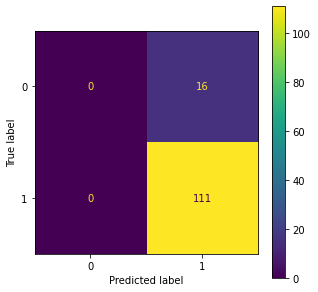

<Figure size 432x288 with 0 Axes>

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(y_test_int, y_pred)
fig = disp.ax_.get_figure()  
fig.set_figwidth(5) 
fig.set_figheight(5)
plt.savefig('figs/matrixconf_cnn_glv.eps', format='eps')
plt.show()

# LSTM

In [ ]:
from keras_tuner import HyperModel

class LSTMHyperModel(HyperModel):
  def __init__(self, embedding_layer, output):
    self.embedding_layer = embedding_layer
    self.output = output

  def build(self, hp):
    model = Sequential()
    model.add(self.embedding_layer)
    model.add(Masking(mask_value=0.0))
    model.add(LSTM(hp.Choice("lstm", [64,128,256]), return_sequences=False, dropout=0.1, recurrent_dropout=0.1))
    model.add(Dense(hp.Choice("dense1", [32,64]), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(self.output, activation='softmax'))
    sgd = SGD(learning_rate=0.01)
    model.compile(loss="categorical_crossentropy",optimizer=sgd,metrics=['accuracy'])
    return model

### WORD2VEC

In [ ]:
embedding_layer = Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM_W2V, weights=[embedding_w2v], input_length=MAX_LENGTH, trainable=False)

In [ ]:
model_LSTM = LSTMHyperModel(embedding_layer, 2)

In [ ]:
tuner = kt.Hyperband(
    model_LSTM,
    objective='val_accuracy',
    max_epochs=30,
    hyperband_iterations=2,
    overwrite=True)

In [ ]:
tuner.search(X_train_w2v_padded,y_train,validation_data=(X_valid_w2v_padded,y_valid),epochs=50)

Trial 6 Complete [00h 00m 05s]
val_accuracy: 0.8984375

Best val_accuracy So Far: 0.8984375
Total elapsed time: 00h 00m 32s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
model = tuner.hypermodel.build(best_hps)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 12, 50)            15300     
                                                                 
 masking_1 (Masking)         (None, 12, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 66        
                                                                 
Total params: 46,886
Trainable params: 31,586
Non-trai

In [ ]:
history_fine = model.fit(X_train_w2v_padded,y_train,validation_data=(X_valid_w2v_padded,y_valid), epochs=100) 

Epoch 1/100
7/7 [==============================] - 4s 95ms/step - loss: 0.6723 - accuracy: 0.7843 - val_loss: 0.6336 - val_accuracy: 0.8984
Epoch 2/100
7/7 [==============================] - 0s 27ms/step - loss: 0.6123 - accuracy: 0.8824 - val_loss: 0.5718 - val_accuracy: 0.8984
Epoch 3/100
7/7 [==============================] - 0s 28ms/step - loss: 0.5649 - accuracy: 0.8824 - val_loss: 0.5250 - val_accuracy: 0.8984
Epoch 4/100
7/7 [==============================] - 0s 27ms/step - loss: 0.5195 - accuracy: 0.8824 - val_loss: 0.4870 - val_accuracy: 0.8984
Epoch 5/100
7/7 [==============================] - 0s 28ms/step - loss: 0.4913 - accuracy: 0.8824 - val_loss: 0.4599 - val_accuracy: 0.8984
Epoch 6/100
7/7 [==============================] - 0s 27ms/step - loss: 0.4521 - accuracy: 0.8824 - val_loss: 0.4353 - val_accuracy: 0.8984
Epoch 7/100
7/7 [==============================] - 0s 28ms/step - loss: 0.4457 - accuracy: 0.8824 - val_loss: 0.4193 - val_accuracy: 0.8984
Epoch 8/100
7/7 [===

In [ ]:
target_names = pd.Categorical(df_indian['diet']).categories

In [ ]:
y_prob = model.predict(X_test_w2v_padded)
y_pred = np.argmax(y_prob,axis=1)
print(classification_report(y_test_int,y_pred, target_names=target_names,zero_division=1))

                precision    recall  f1-score   support

non vegetarian       1.00      0.00      0.00        16
    vegetarian       0.87      1.00      0.93       111

      accuracy                           0.87       127
     macro avg       0.94      0.50      0.47       127
  weighted avg       0.89      0.87      0.82       127



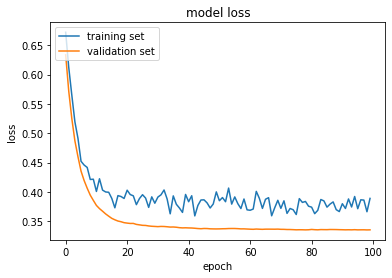

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.savefig('figs/loss_lstm_w2v.eps', format='eps')
plt.show()

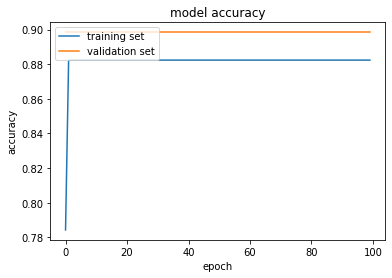

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.savefig('figs/acc_lstm_w2v.eps', format='eps')
plt.show()

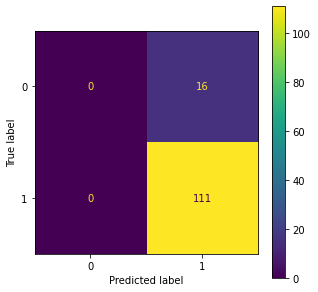

<Figure size 432x288 with 0 Axes>

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(y_test_int, y_pred)
fig = disp.ax_.get_figure()  
fig.set_figwidth(5) 
fig.set_figheight(5)
plt.savefig('figs/matrixconf_lstm_w2v.eps', format='eps')
plt.show()

### GLOVE

In [ ]:
embedding_layer = Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM_GLV, weights=[embedding_glove], input_length=MAX_LENGTH, trainable=False)

In [ ]:
model_LSTM = LSTMHyperModel(embedding_layer, 2)

In [ ]:
tuner = kt.Hyperband(
    model_LSTM,
    objective='val_accuracy',
    max_epochs=30,
    hyperband_iterations=2,
    overwrite=True)

In [ ]:
tuner.search(X_train_glove_padded,y_train,validation_data=(X_valid_glove_padded,y_valid),epochs=50)

Trial 6 Complete [00h 00m 10s]
val_accuracy: 0.8984375

Best val_accuracy So Far: 0.8984375
Total elapsed time: 00h 00m 37s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
model = tuner.hypermodel.build(best_hps)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 12, 50)            15300     
                                                                 
 masking_1 (Masking)         (None, 12, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               91648     
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 66        
                                                                 
Total params: 111,142
Trainable params: 95,842
Non-tra

In [ ]:
history_fine = model.fit(X_train_glove_padded,y_train,validation_data=(X_valid_glove_padded,y_valid), epochs=100) 

Epoch 1/100
7/7 [==============================] - 9s 250ms/step - loss: 0.6753 - accuracy: 0.8480 - val_loss: 0.6436 - val_accuracy: 0.8984
Epoch 2/100
7/7 [==============================] - 1s 126ms/step - loss: 0.6282 - accuracy: 0.8824 - val_loss: 0.5988 - val_accuracy: 0.8984
Epoch 3/100
7/7 [==============================] - 1s 90ms/step - loss: 0.5918 - accuracy: 0.8824 - val_loss: 0.5631 - val_accuracy: 0.8984
Epoch 4/100
7/7 [==============================] - 1s 88ms/step - loss: 0.5546 - accuracy: 0.8824 - val_loss: 0.5296 - val_accuracy: 0.8984
Epoch 5/100
7/7 [==============================] - 1s 118ms/step - loss: 0.5317 - accuracy: 0.8824 - val_loss: 0.5032 - val_accuracy: 0.8984
Epoch 6/100
7/7 [==============================] - 1s 86ms/step - loss: 0.5072 - accuracy: 0.8824 - val_loss: 0.4799 - val_accuracy: 0.8984
Epoch 7/100
7/7 [==============================] - 0s 51ms/step - loss: 0.4884 - accuracy: 0.8824 - val_loss: 0.4609 - val_accuracy: 0.8984
Epoch 8/100
7/7 [

In [ ]:
target_names = pd.Categorical(df_indian['diet']).categories

In [ ]:
y_prob = model.predict(X_test_glove_padded)
y_pred = np.argmax(y_prob,axis=1)
print(classification_report(y_test_int,y_pred, target_names=target_names, zero_division=1))

                precision    recall  f1-score   support

non vegetarian       1.00      0.00      0.00        16
    vegetarian       0.87      1.00      0.93       111

      accuracy                           0.87       127
     macro avg       0.94      0.50      0.47       127
  weighted avg       0.89      0.87      0.82       127



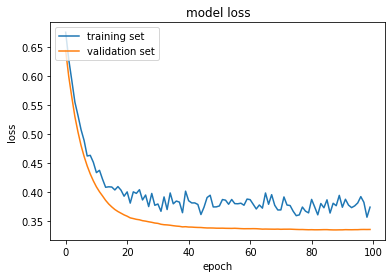

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.savefig('figs/loss_lstm_glv.eps', format='eps')
plt.show()

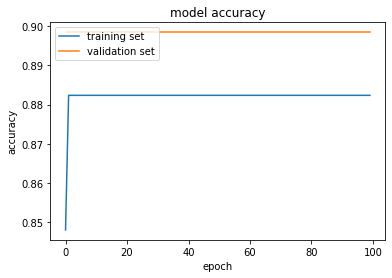

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.savefig('figs/acc_lstm_glv.eps', format='eps')
plt.show()

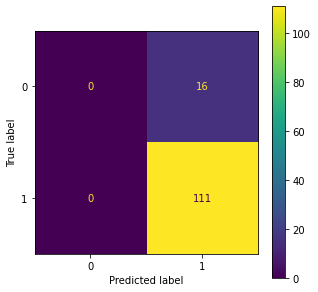

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(y_test_int, y_pred)
fig = disp.ax_.get_figure()  
fig.set_figwidth(5) 
fig.set_figheight(5)
plt.savefig('figs/matrixconf_lstm_glv.eps', format='eps')
plt.show()